# **COVID-19 Analysis** 
<br>
Author: Stephanie Anagnostou 
<br>
MIE 1624 Introduction to Data Science and Analytics
<br>
University of Toronto, Faculty of Engineering
<br>
Dr. Romanko
<br>
April 9, 2020

### Background
In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared a dataset of open sourced research papers. This data-set is a resource of over 45,000 scholarly articles, including over 33,000 with full text, about COVID-19, SARSCoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up and extract insight from this growing body work.
<br>
<br>
The goal of this project is to use NLP and other machine learning algorithms learned in this course to develop a tool that can text-mine this database of research articles to gain useful insights about COVID-19 and how we might be able to tackle the outbreak, contain the spread and flatten the curve. The overarching insights that can be acquired from this dataset are numerous and which aspect of the problem you decide to tackle is up to you. For example you may choose to use this dataset to better understand the transmission, incubation and symptoms of COVID-19, look to gain insights around which therapeutics and vaccines may hold promise and warrant further investigation, or you may wish to investigate the risk factors that make COVID19 particularly deadly in some patients. The underlying goal of this project is to gain insights from this dataset to better inform how our healthcare system, government, industries can tackle this growing problem.

### [Data Cleaning](#Data-Cleaning)
<br>

### [Exploratory Data Analysis](#Exploratory-Data-Analysis)
<br>

### [Model Selection & Deriving Insights](#Model-Selection-&-Deriving-Insights)
<br>

In [2]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap 
from sklearn.decomposition import NMF
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
try:
    from gensim.models import word2vec
except:
    !pip install gensim
    from gensim.models import word2vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from html.parser import HTMLParser
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import SparsePCA
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import itertools    
%matplotlib inline
pd.set_option('display.max_colwidth', None)
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datetime import datetime
import matplotlib.cm as cm

## Data Cleaning

First, I will import the stop words from nltk:

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Cleaning Procedure
1. Process the csv
2. Make all lower case
3. Remove the stop words

In [6]:
def cleanupText(text):
    hparser         = HTMLParser()
    line            = text
    processed_text = line.lower() # lowercase    
    processed_text = word_tokenize(processed_text) 
    processed_text = [w for w in processed_text if not w in stop_words]
    processed_text = (" ").join(processed_text)
    return processed_text

Next, I read the CSV file into a dataframe. Then I apply the cleanup function above to the title and the abstract columns and store the processed strings into two new column called "processed_".

In [7]:
metadata_DF  = pd.read_csv('metadata.csv')
processed_DF = metadata_DF[['title', 'abstract', 'publish_time', 'authors']].copy()

In [8]:
processed_DF['processed_title']    = processed_DF.apply(lambda row: cleanupText(str(row.title)), axis = 1)
processed_DF['processed_abstract'] = processed_DF.apply(lambda row: cleanupText(str(row.abstract)), axis = 1)

Then I will convert the publish times into dates.

In [9]:
processed_DF["publish_time"]       = pd.to_datetime(processed_DF["publish_time"].astype(str), format='%Y-%m-%d')

Then I will keep all the papers that have corona or covid in the title or in the abstract and delete duplicate entries which means that keeps around 10,000 papers.

In [10]:
covid_DF = processed_DF[(processed_DF['processed_abstract'].str.contains('corona')) | 
                        (processed_DF['processed_abstract'].str.contains('covid'))  |
                        (processed_DF['processed_title'].str.contains('corona'))    | 
                        (processed_DF['processed_title'].str.contains('covid'))]
covid_DF.drop_duplicates(keep='first',inplace=True) 

Finally, I will add the Year-Month as a new column. 

In [11]:
covid_DF["monthYear"] = covid_DF["publish_time"].dt.strftime('%Y-%m')

## Exploratory Data Analysis

First I will investigate how the number of papers changed per month. Below in the graph I noticed there is a huge increase the past 3 months for the research papers. 

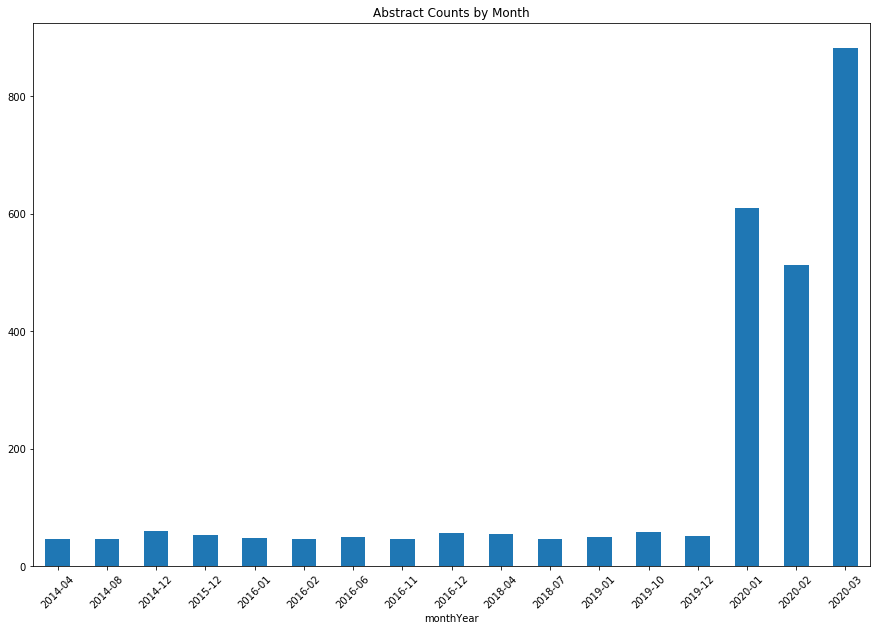

In [12]:
grouped = covid_DF.groupby('monthYear')['abstract'].count()
grouped = grouped[ grouped > 45]
axes= grouped.plot.bar (y= 'abstract count', rot = 45, title='Abstract Counts by Month', figsize=(15,10))
plt.show()

Next, I will find the authors that have written the most papers on the subject.

In [13]:
authorPaperCount =  dict()
for i in covid_DF.index:
    authors   = str(covid_DF['authors'][i]).split(';')
    for author_ in authors:
        if author_ in authorPaperCount:
            authorPaperCount[author_] += 1
        else:
            authorPaperCount[author_] = 1
authorCount_DF = pd.DataFrame(list(authorPaperCount.items()),columns = ['Author','paperCount'])

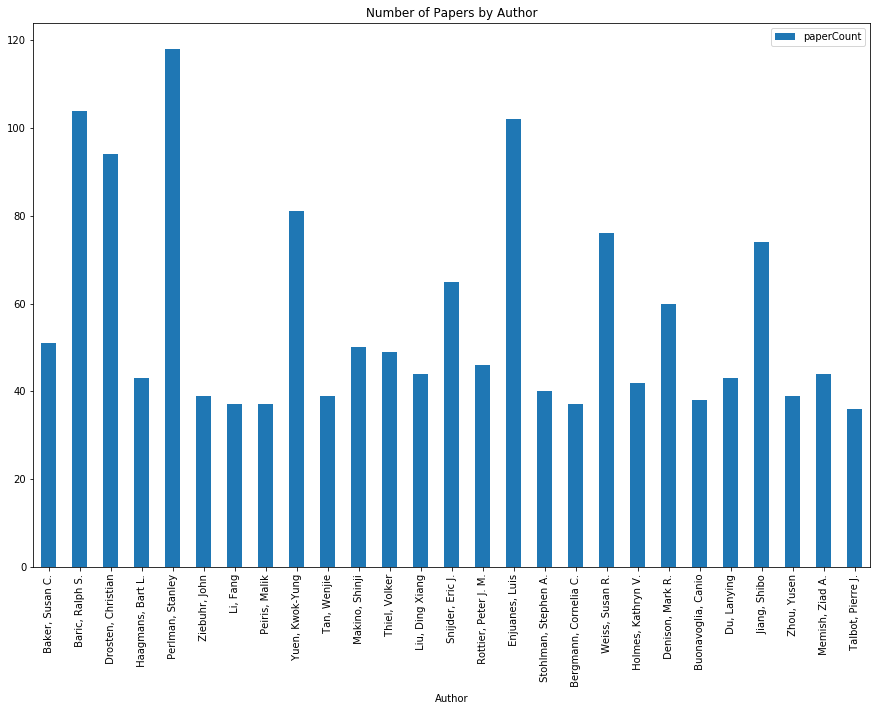

In [14]:
authorCount_DF[ (authorCount_DF['paperCount'] > 35) & (authorCount_DF['Author'] != 'nan') ].plot(kind='bar', 
                    title = 'Number of Papers by Author', x='Author', rot=90, figsize=(15,10))

In [15]:
tfidf  = TfidfVectorizer(
    min_df = 5,
    max_df = 0.70,
    max_features = 100,
    stop_words   = 'english',
    ngram_range = (1,1))
    
tfidf.fit(covid_DF['processed_abstract'])
text = tfidf.transform(covid_DF['processed_abstract'])

In [16]:
tfidf.vocabulary_.keys()

dict_keys(['middle', 'east', 'respiratory', 'syndrome', 'mers', 'cov', 'confirmed', 'infections', 'associated', 'human', 'methods', 'genome', 'infection', 'infectious', 'virus', 'ibv', 'infected', 'clinical', 'strains', 'data', 'role', 'important', 'viral', 'response', 'cells', 'disease', 'treatment', 'viruses', 'studies', 'host', 'different', 'compared', 'gene', 'expression', 'mhv', 'severe', 'influenza', 'mice', 'number', 'antiviral', 'type', 'identified', 'specific', 'used', 'based', 'study', 'model', 'samples', 'novel', 'analysis', 'spike', 'like', 'patients', 'acute', '19', 'results', 'pcr', 'detection', 'immune', 'cell', 'detected', 'strain', 'sequence', 'rna', 'activity', 'new', 'using', 'including', 'epidemic', 'potential', 'outbreak', 'protein', 'replication', 'control', 'health', 'sars', 'coronaviruses', 'positive', 'high', 'proteins', 'receptor', 'reported', 'time', 'showed', 'cases', 'binding', '2019', 'ncov', 'pneumonia', 'transmission', 'china', 'risk', '10', 'group', 'da

Finally, I will find the words with the highest word count in the abstracts.

In [17]:
wordCount =  dict()
for i in covid_DF.index:
    abstracts = str(covid_DF['processed_abstract'][i]).split(' ')
    for word_ in abstracts:
        if word_ in tfidf.vocabulary_.keys():
            if word_ in wordCount:
                wordCount[word_] += 1
            else:
                wordCount[word_] = 1

wordCount_DF = pd.DataFrame(list(wordCount.items()),columns = ['Word','wordCount'])

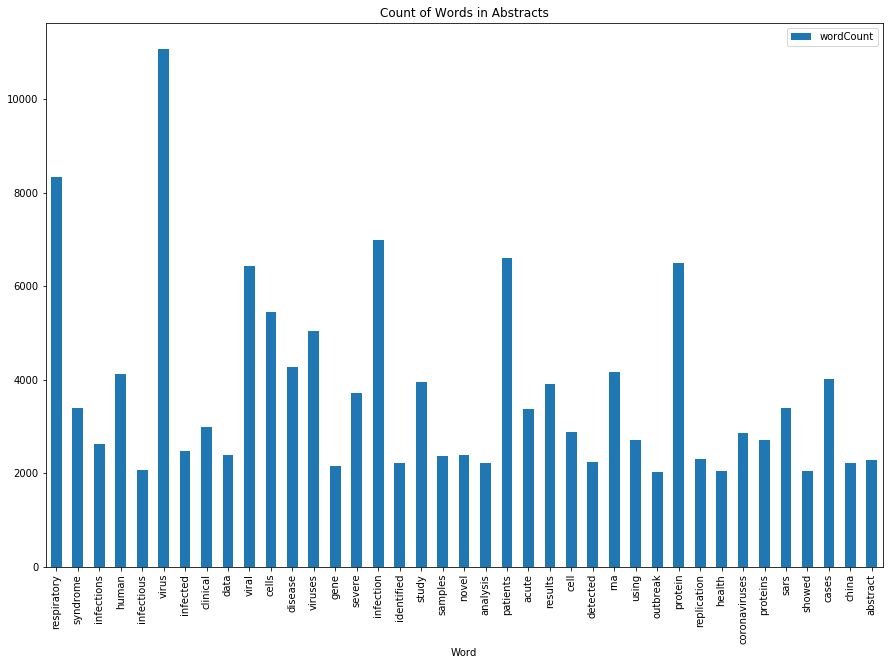

In [18]:
wordCount_DF[wordCount_DF['wordCount'] > 2000].plot(kind='bar', x='Word', title= 'Count of Words in Abstracts', rot=90, figsize=(15,10))

## Model Selection & Deriving Insights

Then I will try NMF clustering with the abstracts.

In [19]:
data= covid_DF['processed_abstract']
vectorizer = TfidfVectorizer(max_features=2000, min_df=10, stop_words='english')
X = vectorizer.fit_transform(data)
X = vectorizer.fit_transform(data)
idx_to_word = np.array(vectorizer.get_feature_names())
 
# apply NMF
nmf = NMF(n_components=20, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_
 
# print the topics
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: house,korean,hong,children,cho,min,asthma,young,park,nan
Topic 2: viral,human,virus,respiratory,coronavirus,syndrome,severe,acute,cov,sars
Topic 3: wuhan,health,epidemic,disease,2020,china,patients,cases,19,covid
Topic 4: 2012,arabia,saudi,respiratory,syndrome,camels,middle,east,cov,mers
Topic 5: rhinovirus,rsv,human,viral,children,infections,virus,influenza,respiratory,viruses
Topic 6: symptoms,samples,respiratory,positive,acute,group,days,clinical,sars,patients
Topic 7: rnas,sequences,transcription,subgenomic,leader,di,synthesis,genome,sequence,rna
Topic 8: disease,il,responses,cns,virus,response,immune,infection,ifn,mice
Topic 9: pigs,antibody,ccov,antibodies,porcine,virus,prcv,transmissible,gastroenteritis,tgev
Topic 10: amino,rbd,receptor,membrane,spike,domain,fusion,proteins,binding,protein
Topic 11: treatment,infection,ace2,december,coronavirus,pneumonia,wuhan,novel,2019,ncov
Topic 12: emc,coronavirus,coronaviruses,hcovs,hku1,human,oc43,229e,nl63,hcov
Topic 13: fecv,cat

From this breakdown, it is evident there are certain animal species which are grouped with illnesses other than coronavirus. For example, Topic 16 has chickens and bronchitis whereas Topic 8 has pigs with gastroenteritis. These groupings could be indicative that certain animal species are being tested in labs and presenting these symptoms. From this, officials may want to have a repository of animal trial data available so researchers can quickly choose the lab tests and understand the past results with ease. 

Below I try the NMF clustering with the titles. 

In [20]:
data= covid_DF['processed_title']
vectorizer = TfidfVectorizer(max_features=2000, min_df=10, max_df=0.7, stop_words='english')
X = vectorizer.fit_transform(data)
X = vectorizer.fit_transform(data)
idx_to_word = np.array(vectorizer.get_feature_names())
 
# apply NMF
nmf = NMF(n_components=10, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_
 
# print the topics
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: saudi,protein,mers,coronavirus,severe,acute,east,middle,respiratory,syndrome
Topic 2: cases,clinical,health,patients,epidemic,outbreak,disease,china,covid,19
Topic 3: domain,receptor,sars,rna,binding,murine,nucleocapsid,spike,coronavirus,protein
Topic 4: clinical,wuhan,outbreak,china,disease,pneumonia,ncov,coronavirus,novel,2019
Topic 5: potential,antibodies,inhibitors,novel,protease,antibody,vaccine,mers,cov,sars
Topic 6: hepatitis,transmissible,feline,diarrhea,gastroenteritis,epidemic,porcine,bronchitis,infectious,virus
Topic 7: disease,patients,tract,emerging,viruses,children,respiratory,coronaviruses,viral,infections
Topic 8: monoclonal,hku1,cell,cells,coronavirus,oc43,nl63,229e,coronaviruses,human
Topic 9: interferon,prevention,response,feline,mice,control,associated,cells,coronavirus,infection
Topic 10: development,reverse,rna,rt,real,time,assay,viruses,pcr,detection


From this information, it is evident there may be strong relationships with some protiens and chemicals the researchers are testing in the lab which for a future paper might be a useful to uncover. Here we can see there is oc43, n163, 229e, hku1 all represented in topic 8. Moreover, in Topic 10 there is rna, assay, pcr, reverse and real time which could be indicative of the lab techniques commonly being used to test COVID-19. 

Now, below I create a function that will be used in kmeans clustering:

In [21]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts    = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Then, I will use MiniBatchKmeans for clustering and plot the error for different cluster sizes to find the elbow and the optimal cluster size. I will start from cluster size 2 and use a step of 3. I create the condition so if a PCA parameter is set, I will do a PCA dimensionality reduction to the data before calculating the best clusters.

In [22]:
def find_optimal_clusters(data, max_k, pca_reduction = None):
    iters = range(2, max_k+10, 3)
    
    sse = []
    if pca_reduction != None:
            transformer   = SparsePCA(n_components=pca_reduction, random_state=0)
            transformer.fit(data.todense())
            X_transformed = transformer.transform(data.todense())
    for k in iters:
        if pca_reduction != None:
            sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(X_transformed).inertia_)
        else:
            sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    plt.show()

Then I plot the clusters using PCA and TSNE.

In [23]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)
    
    pca  = PCA(n_components=50).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx          = np.random.choice(range(pca.shape[0]), size=5000, replace=False)
    label_subset = labels[max_items]
  
    frame     = { 'x': pca[idx, 0],  'y': pca[idx, 1], 'cluster' : label_subset } 
    result_df = pd.DataFrame(frame) 
    
    color_dict = dict({0:'brown',
                  1:'green',
                  2: 'orange',
                  3: 'red',
                  4: 'dodgerblue',
                  5: 'yellow',
                  6: 'blue',
                  7: 'pink',
                  8: 'violet',
                  9: 'turquoise'
                      })


    g = sns.scatterplot(x="x", y="y",   hue="cluster",     data=result_df,   legend='full') # palette=color_dict,
#    g.set(xscale="log");
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset )
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    plt.show()
    
    result_df_10 = result_df[result_df['cluster'] <= 9].copy()
    g2 = sns.scatterplot(x="x", y="y",   hue="cluster",     data=result_df_10,   legend='full', palette=color_dict)
    g2.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.show()

Below, I print the most important words for each cluster.

In [24]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

The next 2 functions do the following:
1. Create the vectorizer
2. Transform the data
3. Find the optimum clusters (elbow plot)
4. Plot the PCA and TSNE
5. Print the top words for each cluster

In [25]:
def analyze_data_part1 (number_of_features, data_column, number_of_clusters):
    tfidf  = TfidfVectorizer(
    min_df = 5,
    max_df = 0.80,
    max_features = number_of_features,
    stop_words   = 'english',
    ngram_range = (1,3))
    
    tfidf.fit(data_column)
    text = tfidf.transform(data_column)
    find_optimal_clusters(text, number_of_clusters, pca_reduction = None)
    return text, tfidf

def analyze_data_part2 ( text,tfidf, number_of_clusters, number_of_top_words):  
    model    = MiniBatchKMeans(n_clusters=number_of_clusters, init_size=1024, batch_size=2048, random_state=20)
    clusters = model.fit_predict(text)
    
    distance_matrix =  dict()
    for i in np.arange(0,number_of_clusters):
        for j in np.arange(i+1,number_of_clusters):
            dist = np.linalg.norm(model.cluster_centers_[i] - model.cluster_centers_[j])
            distance_matrix[i,j] = dist
        

    plot_tsne_pca(text, clusters)
    get_top_keywords(text, clusters, tfidf.get_feature_names(), number_of_top_words)   
    print ('\n Distance between clusters, closest first:')
    print({k: v for k, v in sorted(distance_matrix.items(), key=lambda item: item[1])})

Then we print a 3D plot of a dataframe with 3 features and 1 label which will be used after we apply PCA dimensionality reduction to our data. 

In [26]:
def plot_3D_dataframe (df):
    colors = ["pink", "red", "violet", "blue", 
          "turquoise", "limegreen", "gold", "brown", "green", "yellow"]  # use hex colors here, if desired.
    cmap = ListedColormap(colors)

    rndperm = np.random.permutation(df.shape[0])
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=df.loc[rndperm,:]["pca-one"], 
        ys=df.loc[rndperm,:]["pca-two"], 
        zs=df.loc[rndperm,:]["pca-three"], 
        c=df.loc[rndperm,:]["y"], 
        cmap=cmap
    )

    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    ax.set_zlabel('pca-three')
    plt.show()

In [27]:
def analyze_data_PCA (number_of_features, data_column, number_of_clusters):
    tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = number_of_features,
    stop_words = 'english')
    
    tfidf.fit(data_column)
    text            = tfidf.transform(data_column)
    
    transformer     = SparsePCA(n_components=3, random_state=0)
    transformer.fit(text.todense())
    X_transformed   = transformer.transform(text.todense())
    COLUMN_NAMES    = ['pca-one','pca-two','pca-three']
    df              = pd.DataFrame(columns=COLUMN_NAMES)
    df['pca-one']   = X_transformed[:,0]
    df['pca-two']   = X_transformed[:,1] 
    df['pca-three'] = X_transformed[:,2]
    
    find_optimal_clusters(text, 40, pca_reduction = 3)
    clusters = MiniBatchKMeans(n_clusters=number_of_clusters, init_size=1024, 
                               batch_size=2048, random_state=20).fit_predict(X_transformed)
    
    df['y'] = clusters
    
    plot_3D_dataframe (df)
    #plot_tsne_pca(text, clusters)
    #get_top_keywords(text, clusters, tfidf.get_feature_names(), number_of_top_words) 

Then I will run the elbow method to find the optimum cluster size. 

Fit 2 clusters
Fit 5 clusters
Fit 8 clusters
Fit 11 clusters
Fit 14 clusters
Fit 17 clusters
Fit 20 clusters
Fit 23 clusters
Fit 26 clusters
Fit 29 clusters
Fit 32 clusters
Fit 35 clusters
Fit 38 clusters
Fit 41 clusters
Fit 44 clusters
Fit 47 clusters
Fit 50 clusters
Fit 53 clusters
Fit 56 clusters
Fit 59 clusters
Fit 62 clusters
Fit 65 clusters
Fit 68 clusters
Fit 71 clusters
Fit 74 clusters
Fit 77 clusters


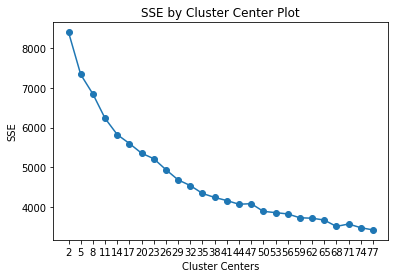

In [28]:
text, tfid  = analyze_data_part1(100, covid_DF.processed_title, 70)

Next, I will plot the graphs for cluster size 50 and I will print the most important words in each cluster. At the end, I will print the distance between all the clusters and see which clusters are 'close.'

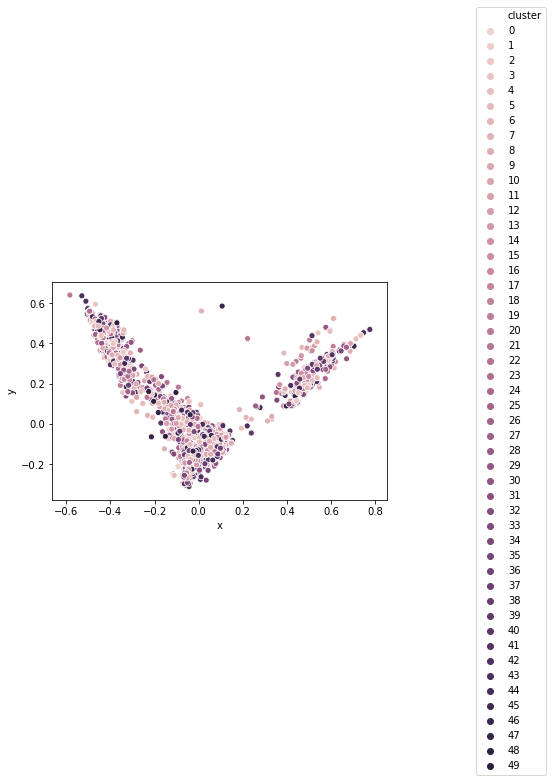

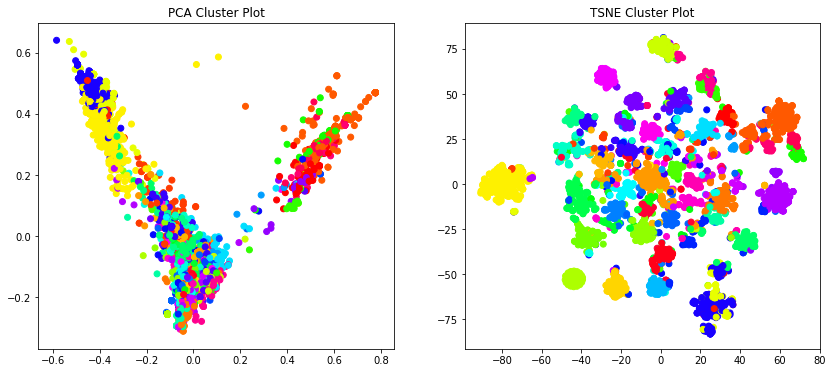

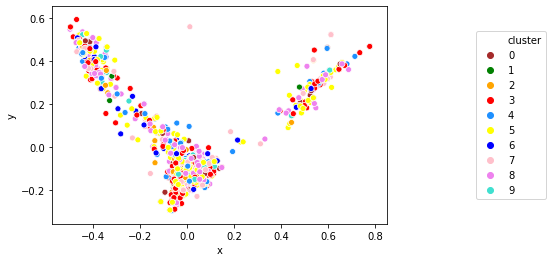


Cluster 0
novel coronavirus,outbreak,china,coronavirus,2019,covid 19,covid,19,disease,coronavirus disease

Cluster 1
respiratory syndrome,syndrome coronavirus,respiratory syndrome coronavirus,middle,middle east,middle east respiratory,east respiratory,east respiratory syndrome,east,response

Cluster 2
patients,viruses,coronavirus,associated,infectious,bovine,acute respiratory,acute,disease,respiratory

Cluster 3
based,novel,analysis,transmission,health,china,outbreak,covid,covid 19,19

Cluster 4
receptor,proteins,cells,spike,human,rna,replication,coronavirus,sars,sars coronavirus

Cluster 5
study,identification,vaccine,proteins,antibodies,analysis,molecular,characterization,bovine,coronavirus

Cluster 6
antibodies,virus,based,viruses,using,coronavirus,respiratory,bovine,pcr,detection

Cluster 7
gene,analysis,protein,coronavirus,virus,infectious bronchitis virus,bronchitis virus,infectious bronchitis,bronchitis,infectious

Cluster 8
respiratory syndrome coronavirus,respiratory,syndrome

In [29]:
analyze_data_part2 ( text, tfid, 50, 10)

Then I will test the same titles with 200 features.

Fit 2 clusters
Fit 5 clusters
Fit 8 clusters
Fit 11 clusters
Fit 14 clusters
Fit 17 clusters
Fit 20 clusters
Fit 23 clusters
Fit 26 clusters
Fit 29 clusters
Fit 32 clusters
Fit 35 clusters
Fit 38 clusters
Fit 41 clusters
Fit 44 clusters
Fit 47 clusters
Fit 50 clusters
Fit 53 clusters
Fit 56 clusters
Fit 59 clusters
Fit 62 clusters
Fit 65 clusters
Fit 68 clusters
Fit 71 clusters
Fit 74 clusters
Fit 77 clusters


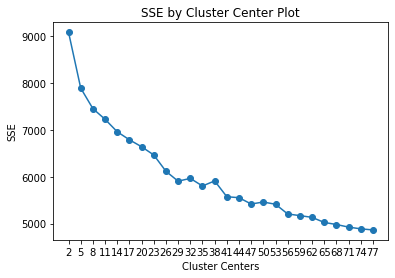

In [30]:
text, tfid  = analyze_data_part1(200, covid_DF.processed_title, 70)

Because there are a lot of clusters I will run based off of the first elbow which happens at approximately 25 clusters. 

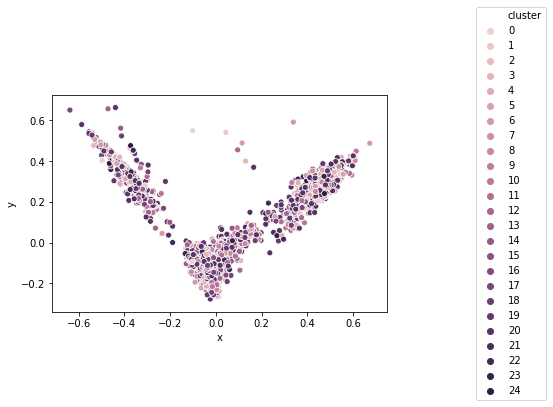

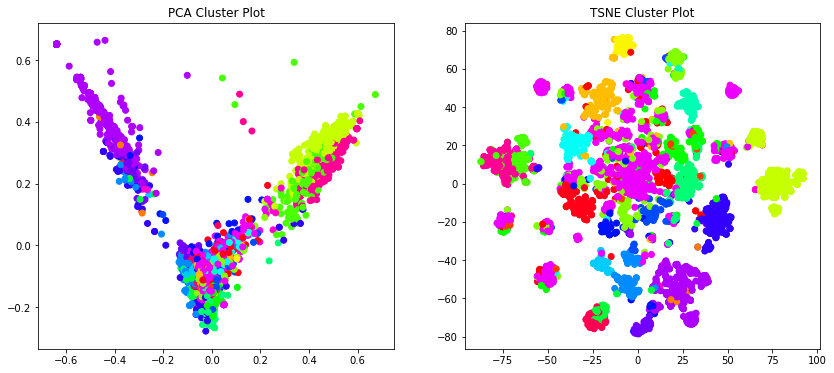

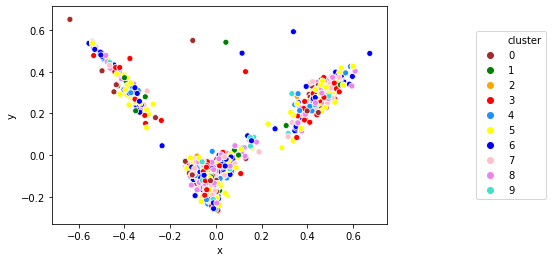


Cluster 0
infectious,sars coronavirus,human,characterization,influenza,virus,sars,coronavirus,protease,like

Cluster 1
transmissible,transmissible gastroenteritis,sars coronavirus,virus,sars,replication,fusion,coronavirus,protein,membrane

Cluster 2
associated,clinical,non,cases,detection,patients,19,covid,covid 19,viral

Cluster 3
rna,enteric,emerging,detection,bat,feline,genetic,bats,human,coronaviruses

Cluster 4
analysis,molecular,antibodies,virus,protein,enteric,detection,coronavirus,bovine coronavirus,bovine

Cluster 5
syndrome coronavirus,respiratory syndrome coronavirus,syndrome,respiratory syndrome,east respiratory syndrome,middle east respiratory,east respiratory,east,middle east,middle

Cluster 6
corona virus,corona,respiratory,rna,mouse hepatitis virus,mouse hepatitis,mouse,hepatitis virus,hepatitis,virus

Cluster 7
sars,respiratory syndrome,respiratory,syndrome,acute respiratory syndrome,severe,severe acute,severe acute respiratory,acute,acute respiratory

Cluster 8
virus

In [31]:
analyze_data_part2 ( text, tfid, 25, 10)

Then I will run the model on the abstracts for 2000 features.

Fit 2 clusters
Fit 5 clusters
Fit 8 clusters
Fit 11 clusters
Fit 14 clusters
Fit 17 clusters
Fit 20 clusters
Fit 23 clusters
Fit 26 clusters
Fit 29 clusters
Fit 32 clusters
Fit 35 clusters
Fit 38 clusters
Fit 41 clusters
Fit 44 clusters
Fit 47 clusters
Fit 50 clusters
Fit 53 clusters
Fit 56 clusters
Fit 59 clusters
Fit 62 clusters
Fit 65 clusters
Fit 68 clusters
Fit 71 clusters
Fit 74 clusters
Fit 77 clusters


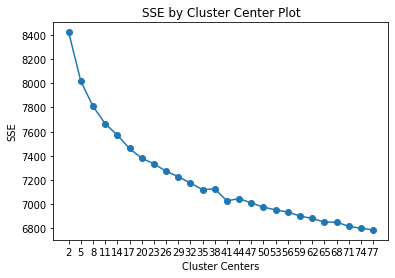

In [32]:
text, tfid  = analyze_data_part1(2000, covid_DF.processed_abstract, 70)

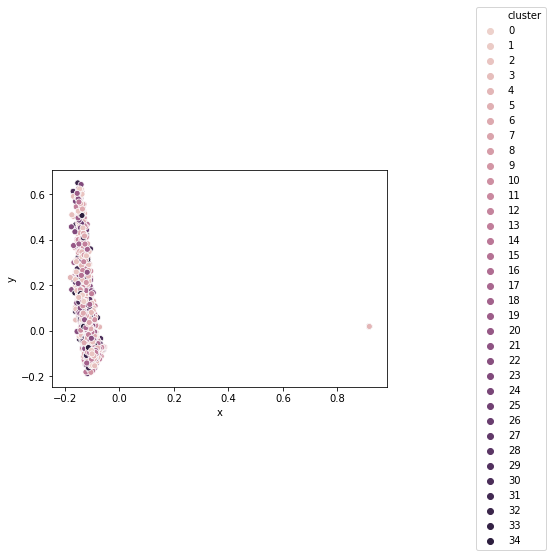

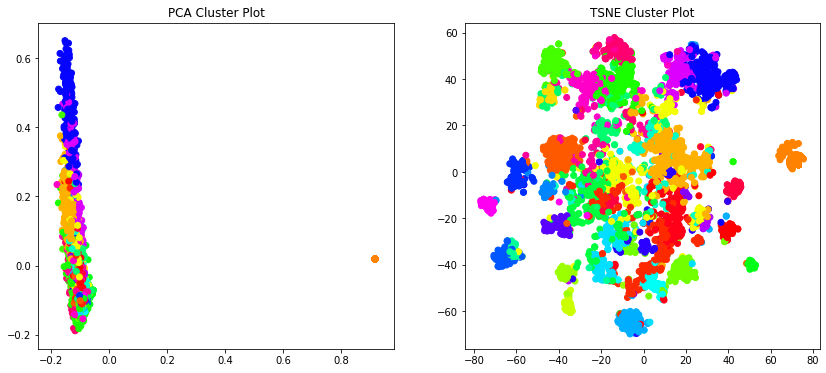

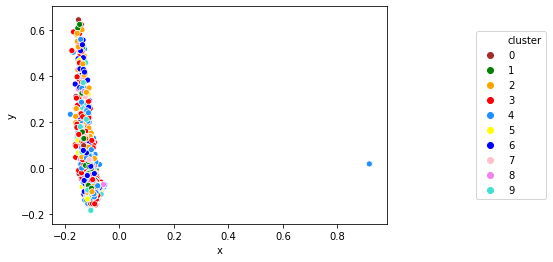


Cluster 0
membrane fusion,protein,sars,cov,membrane,peptides,entry,peptide,cell,fusion

Cluster 1
coronavirus,proteins,replication,protein,sequence,genome,viral,virus,viruses,rna

Cluster 2
viral,patients,rhinovirus,respiratory viruses,infections,virus,children,viruses,influenza,respiratory

Cluster 3
encephalomyelitis,encephalitis,en,employed,emerging infectious,emerging,emergency,emerged,κb,nan

Cluster 4
severe acute,severe acute respiratory,severe,acute respiratory syndrome,coronavirus sars cov,coronavirus sars,protein,cov,sars cov,sars

Cluster 5
diagnosis treatment,prevention,treatment,novel,patients,novel coronavirus,pneumonia,novel coronavirus pneumonia,coronavirus pneumonia,ncp

Cluster 6
respiratory syndrome,syndrome,viral,human,cov,antiviral,respiratory,viruses,sars,virus

Cluster 7
protein,strains,pigs,pedv,swine,diarrhea,piglets,deltacoronavirus,porcine,pdcov

Cluster 8
diarrhea virus,diarrhea virus pedv,epidemic diarrhea virus,virus pedv,porcine epidemic diarrhea,epidemi

In [33]:
analyze_data_part2 ( text, tfid, 35, 10)

Using the 2D cluster graphs above a few key inference can be made about the relationships between the clusters and future research should go into determining whether these relationships can be implemented in lab procedures. For example, one of the smallest distances between cluster 4 and 22 which I grouped as "Protein Reactions" and the other as "Gene Sequencing." The protein reactions cluster contains words such as antibodies, domain, and nucleocapsid whereas the gene sequencing has rna and cell replication. Being able to pair the correct proteins and chemicals with the correct genetic engineering procedures will be essential to developing a vaccine. Therefore, further analyzing the protein reactions and gene sequencing relationships is valuable in the fight against COVID-19.

Below I will calculate the best clusters using PCA dimensionality reduction to 3 dimensions. The clusters are better separated in this case so I will start with 100 features (dimensions). 

Fit 2 clusters
Fit 5 clusters
Fit 8 clusters
Fit 11 clusters
Fit 14 clusters
Fit 17 clusters
Fit 20 clusters
Fit 23 clusters
Fit 26 clusters
Fit 29 clusters
Fit 32 clusters
Fit 35 clusters
Fit 38 clusters
Fit 41 clusters
Fit 44 clusters
Fit 47 clusters


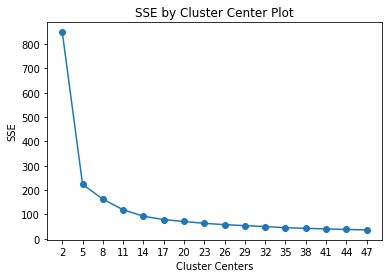

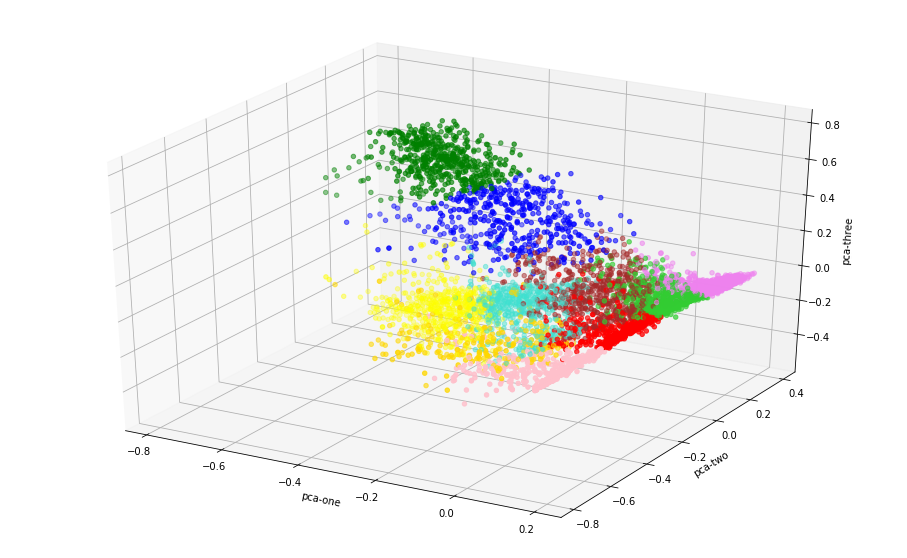

In [34]:
analyze_data_PCA (100, covid_DF.processed_abstract, 10)

Then I will perform PCA with 50 features.

Fit 2 clusters
Fit 5 clusters
Fit 8 clusters
Fit 11 clusters
Fit 14 clusters
Fit 17 clusters
Fit 20 clusters
Fit 23 clusters
Fit 26 clusters
Fit 29 clusters
Fit 32 clusters
Fit 35 clusters
Fit 38 clusters
Fit 41 clusters
Fit 44 clusters
Fit 47 clusters


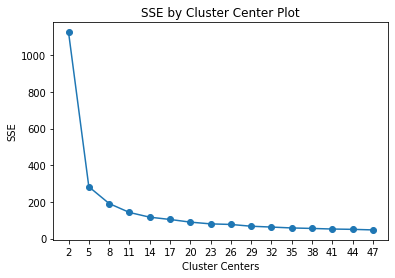

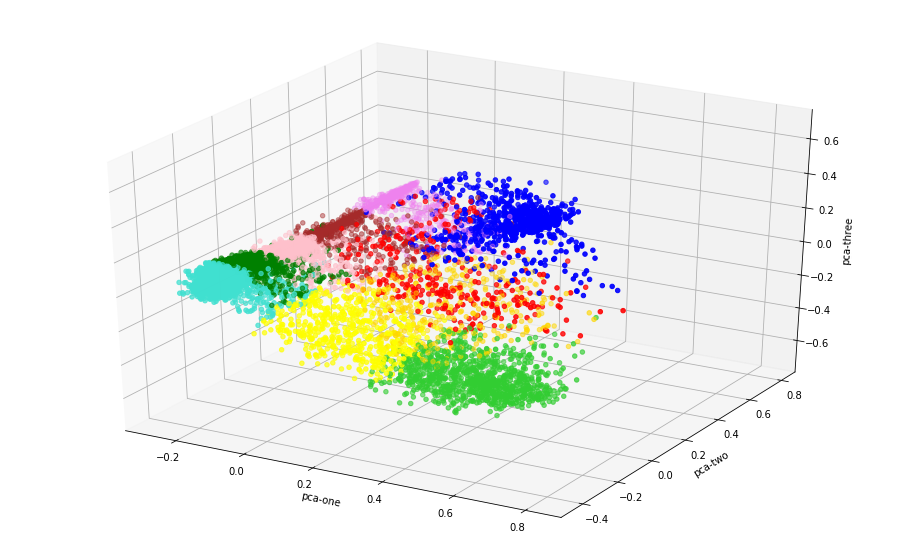

In [35]:
analyze_data_PCA (50, covid_DF.processed_abstract, 10)

For the 3D graphs, there was better clustering. However, it was difficult to identify the words of each cluster once plotted since the PCA uses dimensionality reduction. Consequently, with this graph you can make inferences about which clusters are close to each other based on colour but there is no indication of the words which encompass that cluster. This is one downfall of this methodology and model. Therefore, to derive better insights in a future report I would try to find the original words and map them to the clusters if possible.